In [14]:
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import numpy as np
from keras import backend as k
from keras.datasets import mnist
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy
from keras.models import Model

In [15]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()
image_size=x_train.shape[1]*x_train.shape[1]
x_train=np.reshape(x_train,[-1,image_size]).astype('float32')/255
x_test=np.reshape(x_test,[-1,image_size]).astype('float32')/255


In [16]:
def sampling(args: tuple):
    """
    Reparameterization trick by sampling z from unit Gaussian
    :param args: (tensor, tensor) mean and log of variance of
    q(z|x)
    :returns tensor: sampled latent vector z
    """
# unpack the input tuple
    z_mean, z_log_var = args
    # mini-batch size
    mb_size = k.shape(z_mean)[0]
    # latent space size
    dim = k.int_shape(z_mean)[1]
    # random normal vector with mean=0 and std=1.0
    epsilon = k.random_normal(shape=(mb_size, dim))
    return z_mean + k.exp(0.5 * z_log_var) * epsilon

In [23]:
"""this function will build the vae with separate access to the encoder(single hidden layer with 512 neurons),decoder(same as encoder) and the full network it will return them as tuple, the bottleneck
will have 2 neurons ==> 2 latent variable) """
def build_vae(inter_dim=512,latent_dim=2):
    #ENCODER
    inputs= Input(shape=(image_size,),name='encoder_input')
    x=Dense(inter_dim,activation='relu')(inputs)
    #Latent meand and variance
    z_mean=Dense(latent_dim,name='z_mean')(x)
    z_log_var=Dense(latent_dim,name="z_log_var")(x)
    #reparameterization trick for random sampling
    z=Lambda(sampling,output_shape=(latent_dim,),name='z')([z_mean,z_log_var])
    #full_model of encoder
    encoder=Model(inputs,[z_mean,z_log_var,z],name='encoder')
    encoder.summary()

    #DECODEER
    latent_inputs=Input(shape=(latent_dim,),name='z_sampling')
    x=Dense(inter_dim,activation='relu')(latent_inputs)
    output=Dense(image_size,activation='sigmoid')(x)
    #full model of decoder

    decoder=Model(latent_inputs,output,name='decoder')
    decoder.summary()

    #VAE MODEL
    outputs=decoder(encoder(inputs)[2])
    vae=Model(inputs,outputs,name='VAE')
    #LOSS FCT
    #first we define the construction loss
    reconstruct_loss=binary_crossentropy(inputs,outputs)*image_size
    #next is the kL divergence
    kl_loss=1 + z_log_var -k.square(z_mean)-k.exp(z_log_var)
    kl_loss=k.sum(kl_loss,axis=-1)
    kl_loss*=-0.5
    #we combine them
    vae_loss=k.mean(reconstruct_loss+kl_loss)
    vae.add_loss(vae_loss)
    return encoder,decoder,vae
    






In [18]:
def plot_latent_distribution(encoder,
x_test,
y_test,
batch_size=128):

    """
    Display a 2D plot of the digit classes in the latent space
    We are interested only in z, so we only need the encoder here.
:param encoder: the encoder network
:param x_test: test images
:param y_test: test labels
:param batch_size: size of the mini-batch
"""
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    markers = ('o', 'x', '^', '<', '>', '*', 'h', 'H', 'D', 'd',
    'P', 'X', '8', 's', 'p')
    for i in np.unique(y_test):
        plt.scatter(z_mean[y_test == i, 0], z_mean[y_test == i, 1],marker=MarkerStyle(markers[i],fillstyle='none'),edgecolors='black')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    

In [31]:
def plot_generated_images(decoder):
    """
    Display a 2D plot of the generated images.
    We only need the decoder, because we'll manually sample the
    distribution z
    :param decoder: the decoder network
    """
    # display a nxn 2D manifold of digits
    n = 15
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    # start sampling z1 and z2 in the ranges grid_x and grid_y
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = digit
    # plot the results
    plt.figure(figsize=(6, 5))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense_11[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense_11[0][0]']               
                                                                                            

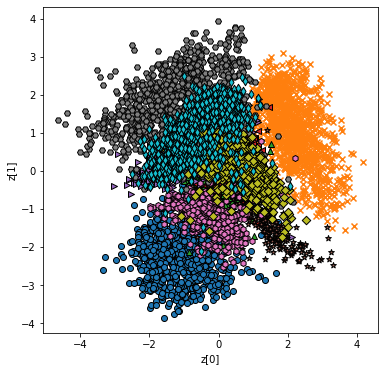

In [24]:
encoder, decoder, vae = build_vae()
vae.compile(optimizer='adam')
vae.summary()
vae.fit(x_train,
epochs=50,
batch_size=128,
validation_data=(x_test, None))
plot_latent_distribution(encoder,
x_test,
y_test,
batch_size=128)
plot_generated_images(decoder)

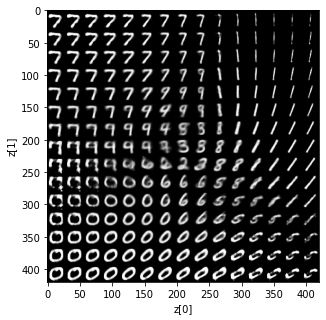

In [32]:
plot_generated_images(decoder)